<p align="center">
    <img src="https://github.com/jessepisel/energy_analytics/blob/master/EA_logo.jpg?raw=true" width="220" height="240" />

</p>

# Neural Networks Validation and Inference
## Freshman Research Initiative Energy Analytics CS 309

#### Jesse Pisel, Assistant Professor of Practice, University of Texas at Austin
**[Twitter](http://twitter.com/geologyjesse)** | **[GitHub](https://github.com/jessepisel)** | **[GoogleScholar](https://scholar.google.com/citations?user=Z4JzYgIAAAAJ&hl=en&oi=ao)** | **[LinkedIn](https://www.linkedin.com/in/jesse-pisel-70519430/)**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import torch
from torch import nn
from sklearn import preprocessing #for label encoding
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
data = pd.read_csv(r'well_data.csv') #read it in
le = preprocessing.LabelEncoder()
top_names = data.TOP
le.fit(data.TOP)
tops = le.transform(data.TOP)
data.drop('TOP', axis=1, inplace=True)

This time we want to split our data into train and test datasets to see how our model is performing

In [3]:
X_train, X_test, y_train, y_test = train_test_split(data.values, tops, test_size=0.2, 
                                                    random_state=86)

And, also construct our test and train loaders

In [4]:
Batch_Size = 64
train = torch.utils.data.TensorDataset(torch.Tensor(np.array(X_train)), 
                                       torch.Tensor(np.array(y_train)))
train_loader = torch.utils.data.DataLoader(train, batch_size = Batch_Size, shuffle = True)

test = torch.utils.data.TensorDataset(torch.Tensor(np.array(X_test)), 
                                      torch.Tensor(np.array(y_test)))
test_loader = torch.utils.data.DataLoader(train, batch_size = Batch_Size, shuffle = True)

features, labels = next(iter(train_loader))

Next, build up a network architecture with 2 hidden layers, with `ReLu` activations, and a `log_softmax` final activation

In [5]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(27, 54)
        self.fc2 = nn.Linear(54, 10)
        self.fc3 = nn.Linear(10, 4)
        self.fc4 = nn.Linear(4, 2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
    
# Hyperparameters for our network
input_size = 27
hidden_sizes = [54, 10]
output_size = 2

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                     )
print(model)

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Do a forward pass
logps = model(features)

# Now we need to calculate our loss (how close are the predictions)
loss = criterion(logps, labels.type(torch.LongTensor))

print(loss)

Sequential(
  (0): Linear(in_features=27, out_features=54, bias=True)
  (1): ReLU()
  (2): Linear(in_features=54, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=2, bias=True)
)
tensor(65.8329, grad_fn=<NllLossBackward>)


Instantiate our model, and since the output is `log_softmax` we need to take the exponential to get the probabilities. After that we want to choose the highest probability using the `.topk` method on our probabilities

In [6]:
model = Classifier()
# Get the class probabilities
probabilities = torch.exp(model(features))
highest_prob, predicted_class = probabilities.topk(1, dim=1)
print(predicted_class[:10,:])

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])


Once we have the predicted labels, we want to define the accuracy. To do this we want to compare the predicted class with the actual class. So we take the labels, reshape them, and check if they are equal to the predictions

In [7]:
correct = predicted_class == labels.view(*predicted_class.shape)
print(correct[:10])

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])


We want to convert the true and false values to 0 for incorrect and 1 for correct so we change the type to `FloatTensor`. We then calculate the mean of this tensor to get the accuracy. So for example, if all the values are correct, then they are all 1's and it has 100% accuracy. If they are all wrong they will all be 0's and have 0% accuracy

In [8]:
print(f'Accuracy is {torch.mean(correct.type(torch.FloatTensor)).item()}')

Accuracy is 0.140625


If we combine all these things together we now have a testing loop that we can run at the end of each epoch. To do the testing, we first turn off gradients with `torch.no_grad()` so that we are not updating our weights on the test data. 

In [9]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses, acc = [], [], []
for e in range(epochs):
    running_loss = 0
    for features, labels in train_loader:
        # Training Pass
        optimizer.zero_grad()
        
        logps = model(features)
        loss = criterion(logps, labels.type(torch.LongTensor))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Testing pass
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for features, labels in test_loader:
                logps = model(features)
                test_loss += criterion(logps, labels.type(torch.LongTensor))
                
                probabilities = torch.exp(model(features))
                highest_prob, predicted_class = probabilities.topk(1, dim=1)
                correct = predicted_class == labels.view(*predicted_class.shape)
                accuracy += torch.mean(correct.type(torch.FloatTensor))
        acc.append(accuracy/len(test_loader))
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print(f"Epoch: {e+1}/{epochs} === ",
              f"Training Loss: {running_loss/len(train_loader):.3} === ",
              f"Test Loss: {test_loss/len(test_loader):.3} === ",
              f"Test Accuracy: {accuracy/len(test_loader):.3f} === ")

Epoch: 1/30 ===  Training Loss: 2.25 ===  Test Loss: 0.57 ===  Test Accuracy: 0.860 === 
Epoch: 2/30 ===  Training Loss: 0.522 ===  Test Loss: 0.477 ===  Test Accuracy: 0.860 === 
Epoch: 3/30 ===  Training Loss: 0.418 ===  Test Loss: 0.311 ===  Test Accuracy: 0.937 === 
Epoch: 4/30 ===  Training Loss: 0.158 ===  Test Loss: 0.129 ===  Test Accuracy: 0.938 === 
Epoch: 5/30 ===  Training Loss: 0.148 ===  Test Loss: 0.125 ===  Test Accuracy: 0.938 === 
Epoch: 6/30 ===  Training Loss: 0.128 ===  Test Loss: 0.145 ===  Test Accuracy: 0.928 === 
Epoch: 7/30 ===  Training Loss: 0.133 ===  Test Loss: 0.179 ===  Test Accuracy: 0.891 === 
Epoch: 8/30 ===  Training Loss: 0.132 ===  Test Loss: 0.118 ===  Test Accuracy: 0.957 === 
Epoch: 9/30 ===  Training Loss: 0.112 ===  Test Loss: 0.125 ===  Test Accuracy: 0.936 === 
Epoch: 10/30 ===  Training Loss: 0.108 ===  Test Loss: 0.129 ===  Test Accuracy: 0.935 === 
Epoch: 11/30 ===  Training Loss: 0.119 ===  Test Loss: 0.0959 ===  Test Accuracy: 0.968 ===

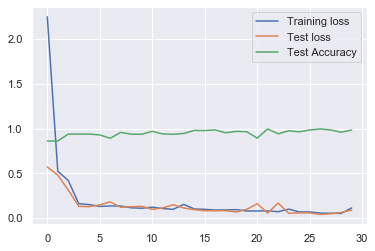

In [10]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.plot(acc, label='Test Accuracy')
plt.legend()

Now we want to make predictions with our model. It's really easy, just call the `.eval` method on the model and feed in some data

In [11]:
model.eval()
# grab the next batch of samples to get predictions
features, labels = next(iter(train_loader))

with torch.no_grad():
    output = model.forward(features)
probabilities = torch.exp(output)
highest_prob, predicted_class = probabilities.topk(1, dim=1)


Text(0.5, 12.5, 'Predicted Label')

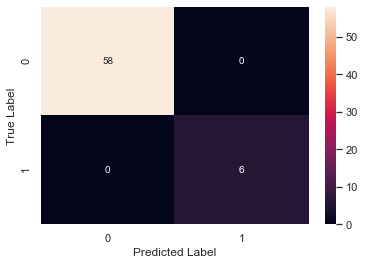

In [12]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(labels, predicted_class.view(Batch_Size).numpy(), labels=[0, 1]), annot=True)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')